Epoch 1/100
300/300 [==============================] - 1s 2ms/step - loss: 4.4497 - mean_absolute_error: 1.5321 - val_loss: 2.6962 - val_mean_absolute_error: 1.2109
Epoch 2/100
300/300 [==============================] - 0s 2ms/step - loss: 2.4633 - mean_absolute_error: 1.2185 - val_loss: 2.1503 - val_mean_absolute_error: 1.2069
Epoch 3/100
300/300 [==============================] - 0s 1ms/step - loss: 2.1378 - mean_absolute_error: 1.1795 - val_loss: 1.9211 - val_mean_absolute_error: 1.1249
Epoch 4/100
300/300 [==============================] - 0s 1ms/step - loss: 1.9253 - mean_absolute_error: 1.1041 - val_loss: 1.7199 - val_mean_absolute_error: 1.0536
Epoch 5/100
300/300 [==============================] - 0s 1ms/step - loss: 1.7343 - mean_absolute_error: 1.0324 - val_loss: 1.5459 - val_mean_absolute_error: 0.9907
Epoch 6/100
300/300 [==============================] - 0s 1ms/step - loss: 1.5748 - mean_absolute_error: 0.9686 - val_loss: 1.3916 - val_mean_absolute_error: 0.9128
Epoch 7/10

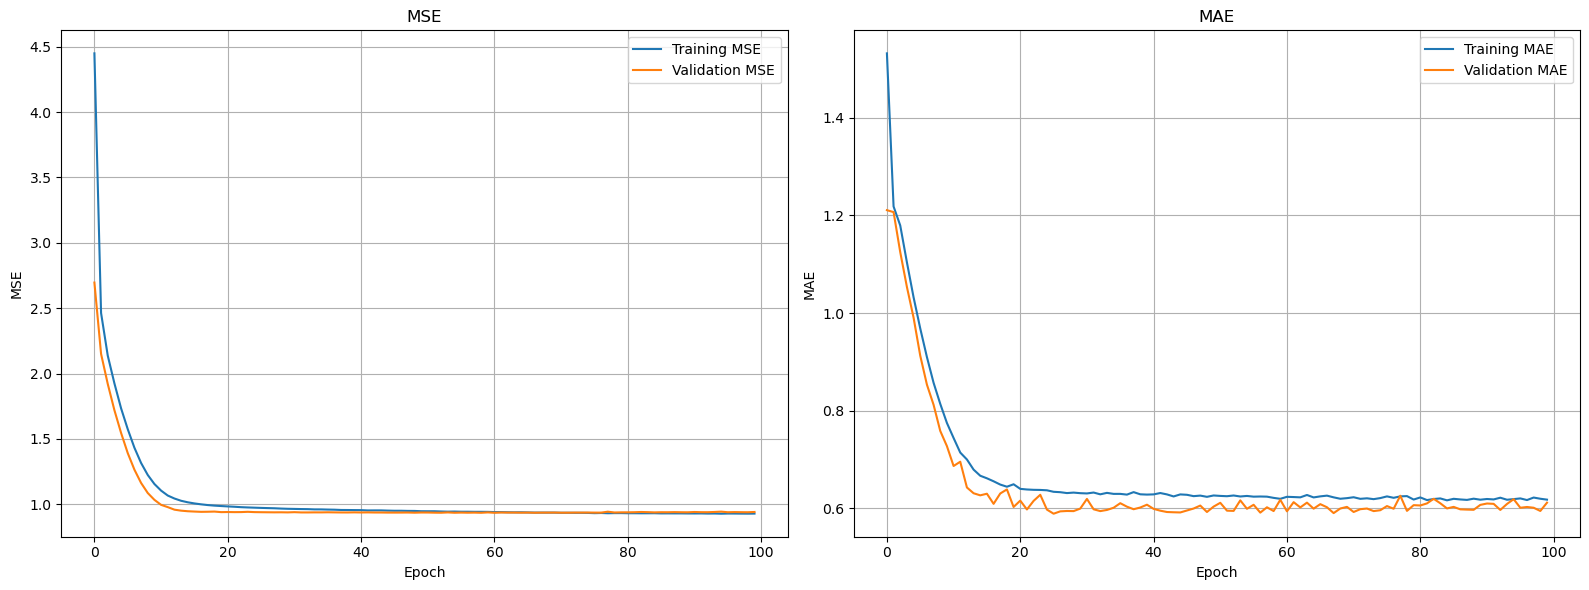

19/19 [==============================] - 0s 942us/step
R-Squared Test Score: 0.6165970161033452


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import joblib
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras import backend as K
from tensorflow.keras.utils import register_keras_serializable
class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = gamma

    def build(self, input_shape):
        # Create a trainable weight variable for the centers of the RBFs
        self.centers = self.add_weight(name='centers',
                                      shape=(self.units, input_shape[-1]),
                                      initializer='uniform',
                                      trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        # Calculate the radial basis functions for each input sample and each RBF center
        diff = K.expand_dims(inputs) - self.centers  # shape: (batch_size, units, input_dim)
        norm = K.sum(K.square(diff), axis=-1)  # shape: (batch_size, units)
        rbf = K.exp(-self.gamma * norm)  # shape: (batch_size, units)

        return rbf

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.units
    
url = 'https://raw.githubusercontent.com/ravsssh/HandballPrediction/main/Handball%20Prediction/datashotiqr/P.csv'
df = pd.read_csv(url, delimiter=',')
# Menentukan input(X) dan output (y)
X = df.drop(columns=["SHOT","GOAL","7MSHOT","6MSHOT","9MSHOT","WINGSHOT","PIVOTSHOT","FASTBREAKSHOT"])
y = df.GOAL
# Membagi dataset 80:20 untuk train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# normalisasi dataset agar tidak bias
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Save the scaler to a file
scaler_filename = 'scaler.gz'
joblib.dump(scaler, scaler_filename)

validation_results_df = pd.DataFrame(columns=['R2_Test', 'MSE', 'MAE'])

# menyimpan hasil metrik evaluasi
validation_results_df = pd.DataFrame(columns=['R2_Test', 'MSE', 'MAE'])
# membuat model
model = Sequential()
model.add(Flatten(input_shape=(6,)))
model.add(RBFLayer(6, 0.5))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='rmsprop', loss=mean_squared_error, metrics=['mean_absolute_error']) 
history = model.fit(X_train, y_train, batch_size=8, epochs=100, validation_data=(X_test, y_test))
model.save("model.keras")
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.title('MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.grid(True)
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.grid(True)
plt.legend()



plt.tight_layout()
plt.show()
pred_test = model.predict(X_test)
r2_test = r2_score(y_test, pred_test)
print(f"R-Squared Test Score: {r2_test}")